In [1]:
import cv2, math, time, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

from google.colab import files

# Upload the same movement video you used in Track A
print("Upload the same movement video (10–20 seconds)...")
uploaded = files.upload()
video_name = list(uploaded.keys())[0]
VIDEO_PATH = "/content/" + video_name
print("Using video:", VIDEO_PATH)

TARGET_FPS = 4          # same as Track A or adjust
WINDOW_SECONDS = 3.0
STRIDE_SECONDS = 1.5

def load_and_sample_frames(video_path, target_fps=TARGET_FPS):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_s = total_frames / orig_fps

    frame_interval = max(int(round(orig_fps / target_fps)), 1)

    frames = []
    timestamps = []

    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_interval == 0:
            t = idx / orig_fps
            frames.append(frame)        # BGR frame
            timestamps.append(t)
        idx += 1

    cap.release()
    print(f"Original FPS: {orig_fps:.2f}, frames: {total_frames}, duration: {duration_s:.2f}s")
    print(f"Sampled {len(frames)} frames at ~{target_fps} FPS.")
    return frames, timestamps, duration_s

frames, ts, vid_duration = load_and_sample_frames(VIDEO_PATH)
print("Video duration ~", vid_duration, "seconds")


Upload the same movement video (10–20 seconds)...


Saving 5319088-uhd_2160_3840_25fps.mp4 to 5319088-uhd_2160_3840_25fps.mp4
Using video: /content/5319088-uhd_2160_3840_25fps.mp4
Original FPS: 25.00, frames: 562, duration: 22.48s
Sampled 94 frames at ~4 FPS.
Video duration ~ 22.48 seconds


In [2]:
def compute_motion_signal(frames, timestamps):
    """Return DataFrame with per-frame motion magnitude over time."""
    gray = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames]
    motion_scores = [0.0]   # first frame has no previous

    for i in range(1, len(gray)):
        diff = cv2.absdiff(gray[i], gray[i-1])
        motion_scores.append(float(diff.mean()))

    df_sig = pd.DataFrame({
        "frame_idx": np.arange(len(frames)),
        "time_sec": timestamps,
        "motion": motion_scores,
    })
    return df_sig

df_sig = compute_motion_signal(frames, ts)
df_sig.head()


,frame_idx,time_sec,motion
0,0,0.00,0.000000
1,1,0.24,7.035971
2,2,0.48,6.492401
3,3,0.72,6.085333
4,4,0.96,8.715046


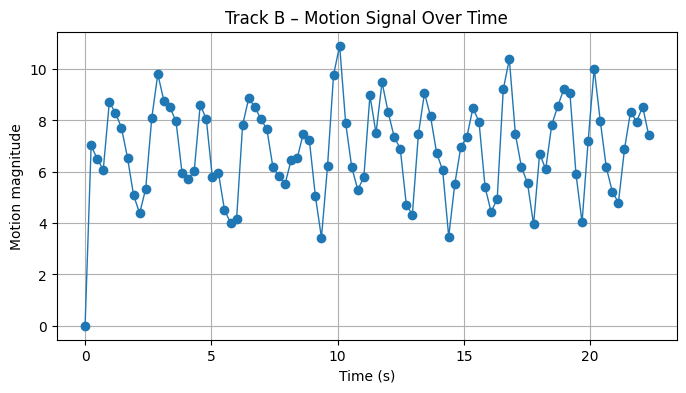

In [3]:
plt.figure()
plt.plot(df_sig["time_sec"], df_sig["motion"], marker="o", linewidth=1)
plt.title("Track B – Motion Signal Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Motion magnitude")
plt.show()

In [4]:
def detect_repetitions(df_sig, prominence_factor=0.7, min_distance_sec=0.5):
    """
    Detect repetitions as peaks in the motion signal.
    - prominence_factor: fraction of (max - mean) used as threshold.
    - min_distance_sec: minimum time between peaks.
    Returns DataFrame with one row per repetition.
    """
    times = df_sig["time_sec"].values
    motion = df_sig["motion"].values

    if len(motion) < 3:
        return pd.DataFrame(columns=["rep_id", "peak_time", "peak_motion"])

    mean_m = motion.mean()
    max_m = motion.max()
    if max_m <= mean_m:
        thr = mean_m
    else:
        thr = mean_m + prominence_factor * (max_m - mean_m)

    reps = []
    last_peak_time = -1e9
    rep_id = 0

    for i in range(1, len(motion) - 1):
        if motion[i] > motion[i-1] and motion[i] > motion[i+1] and motion[i] >= thr:
            t = times[i]
            if t - last_peak_time >= min_distance_sec:
                reps.append({
                    "rep_id": rep_id,
                    "peak_time": t,
                    "peak_motion": motion[i],
                    "peak_frame_idx": int(df_sig.loc[i, "frame_idx"]),
                })
                last_peak_time = t
                rep_id += 1

    return pd.DataFrame(reps)

df_reps = detect_repetitions(df_sig)
df_reps


,rep_id,peak_time,peak_motion,peak_frame_idx
0,0,2.88,9.807975,12
1,1,10.08,10.912748,42
2,2,16.80,10.388094,70
3,3,20.16,10.020245,84


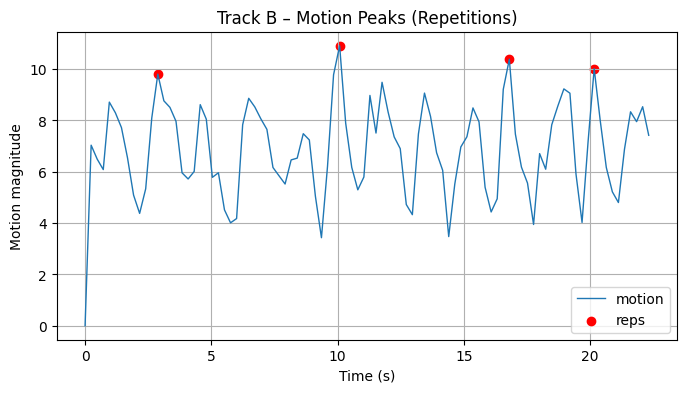

In [5]:
plt.figure()
plt.plot(df_sig["time_sec"], df_sig["motion"], label="motion", linewidth=1)
if not df_reps.empty:
    plt.scatter(df_reps["peak_time"], df_reps["peak_motion"], color="red", label="reps")
plt.title("Track B – Motion Peaks (Repetitions)")
plt.xlabel("Time (s)")
plt.ylabel("Motion magnitude")
plt.legend()
plt.show()


In [6]:
def estimate_rep_segments(df_reps, total_duration):
    """
    Given repetition peaks, estimate start/end times of each repetition
    using midpoints between neighbor peaks.
    """
    if df_reps.empty:
        return pd.DataFrame(columns=["rep_id", "start_sec", "end_sec", "duration_sec", "peak_time", "peak_motion"])

    df = df_reps.sort_values("peak_time").reset_index(drop=True)
    peaks = df["peak_time"].values

    starts = []
    ends = []

    for i, t in enumerate(peaks):
        if i == 0:
            prev_mid = max(0.0, t - (peaks[i+1] - t) / 2) if len(peaks) > 1 else max(0.0, t - 0.5)
        else:
            prev_mid = (peaks[i-1] + t) / 2

        if i == len(peaks) - 1:
            next_mid = min(total_duration, t + (t - peaks[i-1]) / 2) if len(peaks) > 1 else min(total_duration, t + 0.5)
        else:
            next_mid = (t + peaks[i+1]) / 2

        starts.append(prev_mid)
        ends.append(next_mid)

    durations = np.maximum(0.0, np.array(ends) - np.array(starts))

    df["start_sec"] = starts
    df["end_sec"] = ends
    df["duration_sec"] = durations

    return df[["rep_id", "start_sec", "end_sec", "duration_sec", "peak_time", "peak_motion"]]

df_rep_segments = estimate_rep_segments(df_reps, vid_duration)
df_rep_segments


,rep_id,start_sec,end_sec,duration_sec,peak_time,peak_motion
0,0,0.00,6.48,6.48,2.88,9.807975
1,1,6.48,13.44,6.96,10.08,10.912748
2,2,13.44,18.48,5.04,16.80,10.388094
3,3,18.48,21.84,3.36,20.16,10.020245


In [7]:
num_reps = len(df_rep_segments)
avg_rep_duration = df_rep_segments["duration_sec"].mean() if num_reps > 0 else float("nan")
freq_reps_per_sec = num_reps / vid_duration if vid_duration > 0 else float("nan")

print(f"Estimated repetitions: {num_reps}")
print(f"Average duration per repetition: {avg_rep_duration:.2f} s")
print(f"Repetition frequency: {freq_reps_per_sec:.3f} reps/sec")


Estimated repetitions: 4
Average duration per repetition: 5.46 s
Repetition frequency: 0.178 reps/sec


In [8]:
EXPECTED_REPS = 5   # change as per your clip

rep_count_error = abs(num_reps - EXPECTED_REPS)
if EXPECTED_REPS > 0:
    step_accuracy = max(0.0, 1.0 - rep_count_error / EXPECTED_REPS)
else:
    step_accuracy = float("nan")

print(f"Expected repetitions: {EXPECTED_REPS}")
print(f"Estimated repetitions: {num_reps}")
print(f"Repetition count error (MAE): {rep_count_error}")
print(f"Step / sequence accuracy (0–1): {step_accuracy:.3f}")


Expected repetitions: 5
Estimated repetitions: 4
Repetition count error (MAE): 1
Step / sequence accuracy (0–1): 0.800


In [9]:
t0 = time.time()

# recompute signal & reps for latency measure
df_sig_tmp = compute_motion_signal(frames, ts)
df_reps_tmp = detect_repetitions(df_sig_tmp)
df_rep_segments_tmp = estimate_rep_segments(df_reps_tmp, vid_duration)

t1 = time.time()
trackB_latency_s = t1 - t0
trackB_latency_ms = trackB_latency_s * 1000.0
trackB_rtf = vid_duration / trackB_latency_s if trackB_latency_s > 0 else float("inf")

print(f"Track B processing latency: {trackB_latency_ms:.2f} ms")
print(f"Track B real-time factor (duration / latency): {trackB_rtf:.3f}")


Track B processing latency: 904.73 ms
Track B real-time factor (duration / latency): 24.847


In [11]:
import os

# Save detailed temporal reasoning metrics
TRACKB_DETAILED = "trackB_temporal_metrics.csv"
df_rep_segments.to_csv(TRACKB_DETAILED, index=False)
print("Saved repetition segments to:", TRACKB_DETAILED)

# Summary metrics for metrics_template.csv
summary_rows_B = [
    {"metric": "trackB_num_repetitions",    "value": str(num_reps),            "notes": "Estimated repetition count (temporal reasoning)"},
    {"metric": "trackB_avg_rep_duration_s", "value": f"{avg_rep_duration:.3f}", "notes": "Average repetition duration"},
    {"metric": "trackB_freq_reps_per_sec",  "value": f"{freq_reps_per_sec:.4f}", "notes": "Repetition frequency (reps/sec)"},
    {"metric": "trackB_latency_ms",         "value": f"{trackB_latency_ms:.2f}", "notes": "Track B pipeline latency (ms)"},
    {"metric": "trackB_rtf",                "value": f"{trackB_rtf:.4f}",        "notes": "Real-time factor (video_duration / processing_time)"},
]

# Add error/accuracy if EXPECTED_REPS defined
try:
    EXPECTED_REPS
    summary_rows_B.append({
        "metric": "trackB_rep_count_mae",
        "value": str(rep_count_error),
        "notes": "Absolute error between estimated and expected repetitions"
    })
    summary_rows_B.append({
        "metric": "trackB_step_accuracy",
        "value": f"{step_accuracy:.4f}",
        "notes": "Step/sequence accuracy based on repetition count"
    })
except NameError:
    pass

SUMMARY_CSV = "metrics_template.csv"
if os.path.exists(SUMMARY_CSV):
    metrics_df = pd.read_csv(SUMMARY_CSV)
    # ensure the proper three columns
    if list(metrics_df.columns) != ["metric", "value", "notes"]:
        metrics_df = pd.DataFrame(columns=["metric", "value", "notes"])
else:
    metrics_df = pd.DataFrame(columns=["metric", "value", "notes"])

metrics_df = pd.concat([metrics_df, pd.DataFrame(summary_rows_B)], ignore_index=True)
metrics_df.to_csv(SUMMARY_CSV, index=False)
print("Updated summary metrics in:", SUMMARY_CSV)
metrics_df.tail()

Saved repetition segments to: trackB_temporal_metrics.csv
Updated summary metrics in: metrics_template.csv


,metric,value,notes
2,trackB_freq_reps_per_sec,0.1779,Repetition frequency (reps/sec)
3,trackB_latency_ms,904.73,Track B pipeline latency (ms)
4,trackB_rtf,24.8473,Real-time factor (video_duration / processing_...
5,trackB_rep_count_mae,1,Absolute error between estimated and expected ...
6,trackB_step_accuracy,0.8000,Step/sequence accuracy based on repetition count


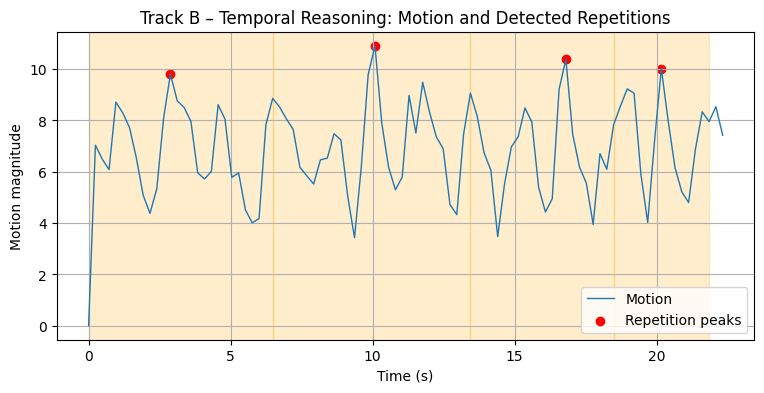

In [12]:
# Motion signal with repetition regions
plt.figure(figsize=(9, 4))
plt.plot(df_sig["time_sec"], df_sig["motion"], label="Motion", linewidth=1)

if not df_rep_segments.empty:
    for _, row in df_rep_segments.iterrows():
        plt.axvspan(row["start_sec"], row["end_sec"], color="orange", alpha=0.2)
    plt.scatter(df_rep_segments["peak_time"], df_rep_segments["peak_motion"], color="red", label="Repetition peaks")

plt.title("Track B – Temporal Reasoning: Motion and Detected Repetitions")
plt.xlabel("Time (s)")
plt.ylabel("Motion magnitude")
plt.legend()
plt.show()
